In [1]:
# %%
%matplotlib inline


In [2]:
# %%
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import os
import pathlib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from dataset import rf_env

dataset_dir = "../dataset/DataCollection0/"
save_dir = "experiments/experiment_0"

env = rf_env(dataset_dir)
pathlib.Path(save_dir).mkdir(parents=True, exist_ok=True)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# %%
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [4]:
# %%
class DQN_Conv(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN_Conv, self).__init__()
        self.conv1 = nn.Conv2d(2, 64, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(1, 3), stride=1, padding=(0, 1))
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=(1, 3), stride=1, padding=(0, 1))
        self.bn3 = nn.BatchNorm2d(64)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(n_observations * 64, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = self.flatten(x)
        x = self.fc(x)
        return x

In [5]:
# %%

class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


In [6]:
# %%
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 1024
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 10000
TAU = 0.005
LR = 1e-4

# Get number of actions from the RF environment
n_actions = env.n_actions
# Get the number of state observations
state, _ = env.reset()
# FIXME: return signal power and sns instead of preamble IQ symbols
n_observations = len(state)

# FIXME: return signal power and sns instead of preamble IQ symbols
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(100000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[random.randint(0, env.n_actions - 1)]], device=device, dtype=torch.long)


cumulative_rewards = []


def plot_cumulative_reward(show_result=False):
    fig = plt.figure()
    rewards_t = torch.tensor(cumulative_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Rewards')
    plt.plot(rewards_t.numpy())
    # Take 100 episode averages and plot them too
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        # means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
    
    return fig


In [7]:
# %%
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


Complete


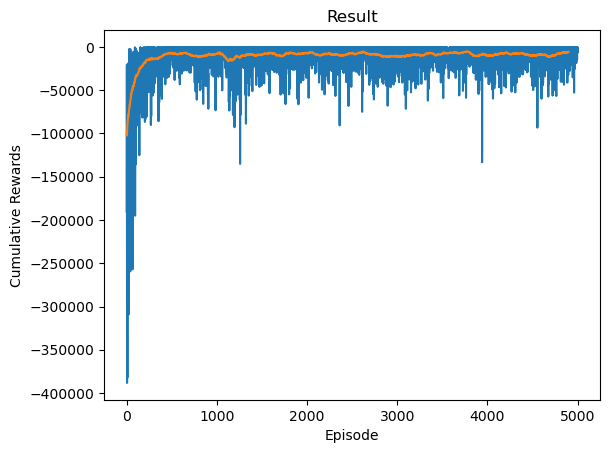

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
# %%
if torch.cuda.is_available():
    num_episodes = 5000
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    cumulative_reward = 0

    for t in count():
        # print(state.shape)
        action = select_action(state)
        observation, reward, terminated, measures = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        cumulative_reward += reward
        done = terminated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            cumulative_rewards.append(cumulative_reward)
            # plot_cumulative_reward()
            break

print('Complete')
fig = plot_cumulative_reward(show_result=True)
plt.ioff()
plt.show()
fig.savefig(os.path.join(save_dir, "train_cumulative_rewards.pdf"))


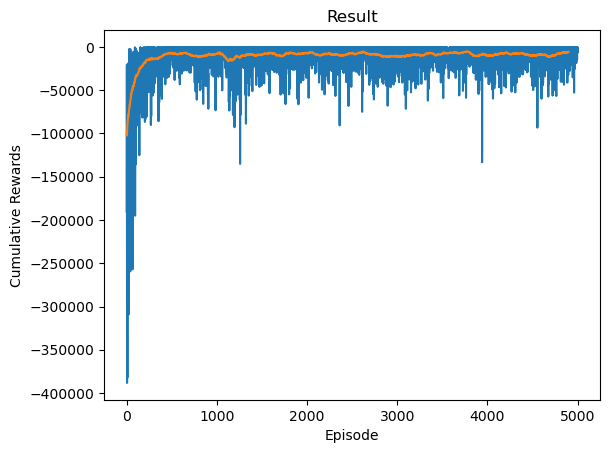

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [13]:
# %%
fig = plot_cumulative_reward(show_result=True)
plt.ioff()
plt.show()


In [10]:
# %%
torch.save(cumulative_rewards, os.path.join(save_dir, "train_cumulative_rewards.pt"))
torch.save(policy_net.state_dict(), os.path.join(save_dir, "policy_state.pt"))
torch.save(policy_net, os.path.join(save_dir, "policy.pt"))


In [ ]:
# %%
policy_net.load_state_dict(torch.load(os.path.join(save_dir, "policy_state.pt")))
cumulative_rewards = torch.load(os.path.join(save_dir, "train_cumulative_rewards.pt"))

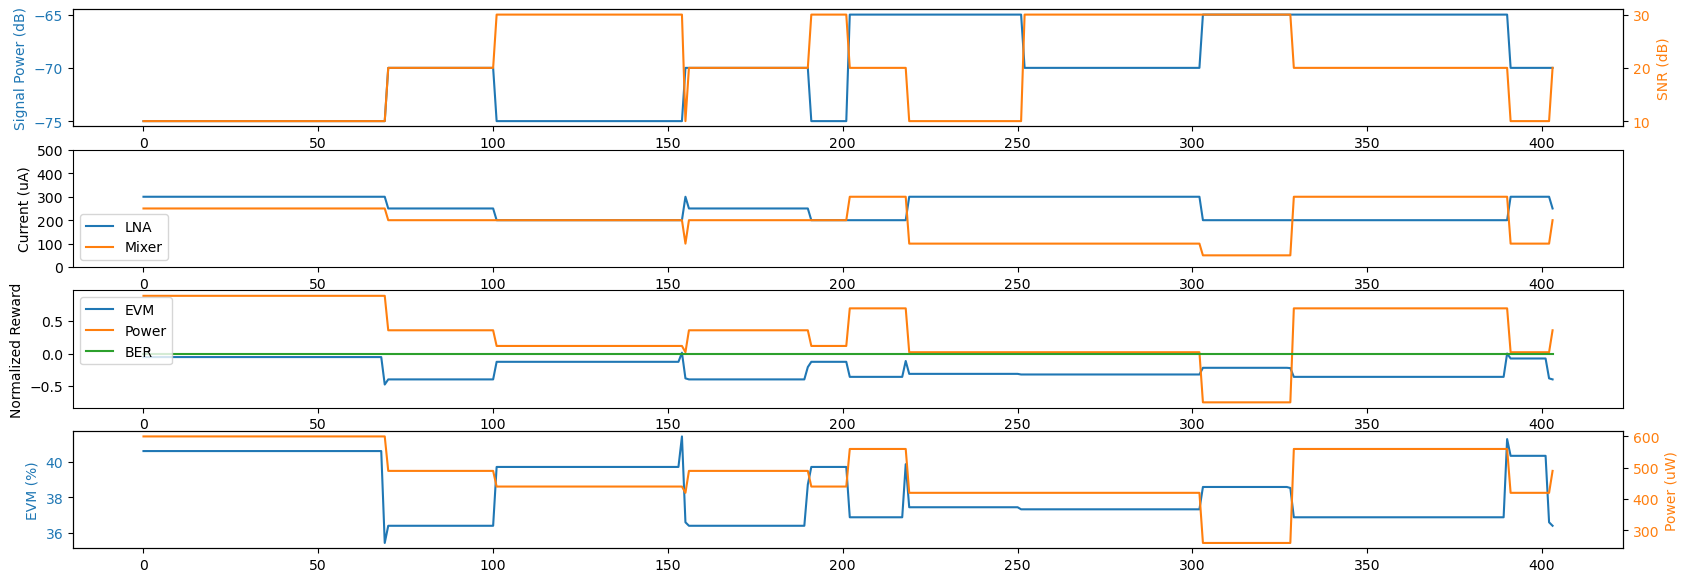

In [45]:
# %%

num_episodes = 4
cumulative_rewards_test = []
signal_powers = []
snrs = []
EVMs = []
powers = []
BERs = []
EVMs_Normalized = []
powers_Normalized = []
BERs_Normalized = []
lna_currents = []
mixer_currents = []

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, _ = env.reset(keep_last_config=True)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    # print(f"Signal Power: {signal_powers[-1]}\tSNR: {snrs[-1]}")

    cumulative_reward_test = 0

    for t in count():
        signal_powers.append(env.comm_config.SignalPower)
        snrs.append(env.comm_config.SNR)

        with torch.no_grad():
            action = policy_net(state).max(1).indices.view(1, 1)
        observation, reward, terminated, measures = env.step(action.item())
        lna_currents.append(env.getLNACurrent())
        mixer_currents.append(env.getMixerCurrent())

        cumulative_reward_test += reward
        EVMs.append(measures['rmsEVM'])
        powers.append(measures['Power'])
        BERs.append(measures['BER'])
        EVMs_Normalized.append(measures['rmsEVM_Normalized'])
        powers_Normalized.append(measures['Power_Normalized'])
        BERs_Normalized.append(measures['BER'])
        
        done = terminated
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Move to the next state
        state = next_state

        if done:
            cumulative_rewards_test.append(cumulative_reward_test)
            break

# plt.figure()
# plt.subplot(4, 1, 1)
# plt.plot(lna_currents)
# plt.title("LNA Current")
# plt.subplot(4, 1, 2)
# plt.plot(mixer_currents)
# plt.title("Mixer Current")
# plt.subplot(4, 1, 3)
# plt.plot(EVMs)
# plt.title("EVM")
# plt.subplot(4, 1, 4)
# plt.plot(powers)
# plt.title("Power Consumption")
# plt.show()

colors = ["tab:blue", "tab:orange"]

fig = plt.figure(figsize=(20, 7))
ax1 = plt.subplot(4, 1, 1)
ax1.plot(signal_powers, color=colors[0])
ax1.set_ylabel("Signal Power (dB)", color=colors[0])
ax1.tick_params(axis="y", labelcolor=colors[0])
ax1.set_yticks(rf_env.SignalPower_List)
ax2 = ax1.twinx()
ax2.plot(snrs, color=colors[1])
ax2.set_ylabel("SNR (dB)", color=colors[1])
ax2.tick_params(axis="y", labelcolor=colors[1])
ax2.set_yticks(rf_env.SNR_List)
plt.subplot(4, 1, 2)
plt.plot(lna_currents)
plt.plot(mixer_currents)
plt.ylabel("Current (uA)")
plt.legend(['LNA', 'Mixer'])
plt.yticks(list(range(0, 600, 100)))
plt.subplot(4, 1, 3)
plt.plot(EVMs_Normalized)
plt.plot(powers_Normalized)
plt.plot(BERs_Normalized)
plt.ylabel("Normalized Reward")
plt.legend(['EVM', 'Power', 'BER'])
ax1 = plt.subplot(4, 1, 4)
ax1.plot(EVMs, color=colors[0])
ax1.set_ylabel("EVM (%)", color=colors[0])
ax1.tick_params(axis="y", labelcolor=colors[0])
ax2 = ax1.twinx()
ax2.plot(powers, color=colors[1])
ax2.set_ylabel("Power (uW)", color=colors[1])
ax2.tick_params(axis="y", labelcolor=colors[1])
# print(f"EVM: min: {min(EVMs)}, max: {max(EVMs)}, range: {max(EVMs) - min(EVMs)}")
# print(f"Power: min: {min(powers)}, max: {max(powers)}, range: {max(powers) - min(powers)}")
plt.show()
fig.savefig(os.path.join(save_dir, "test_results.pdf"))


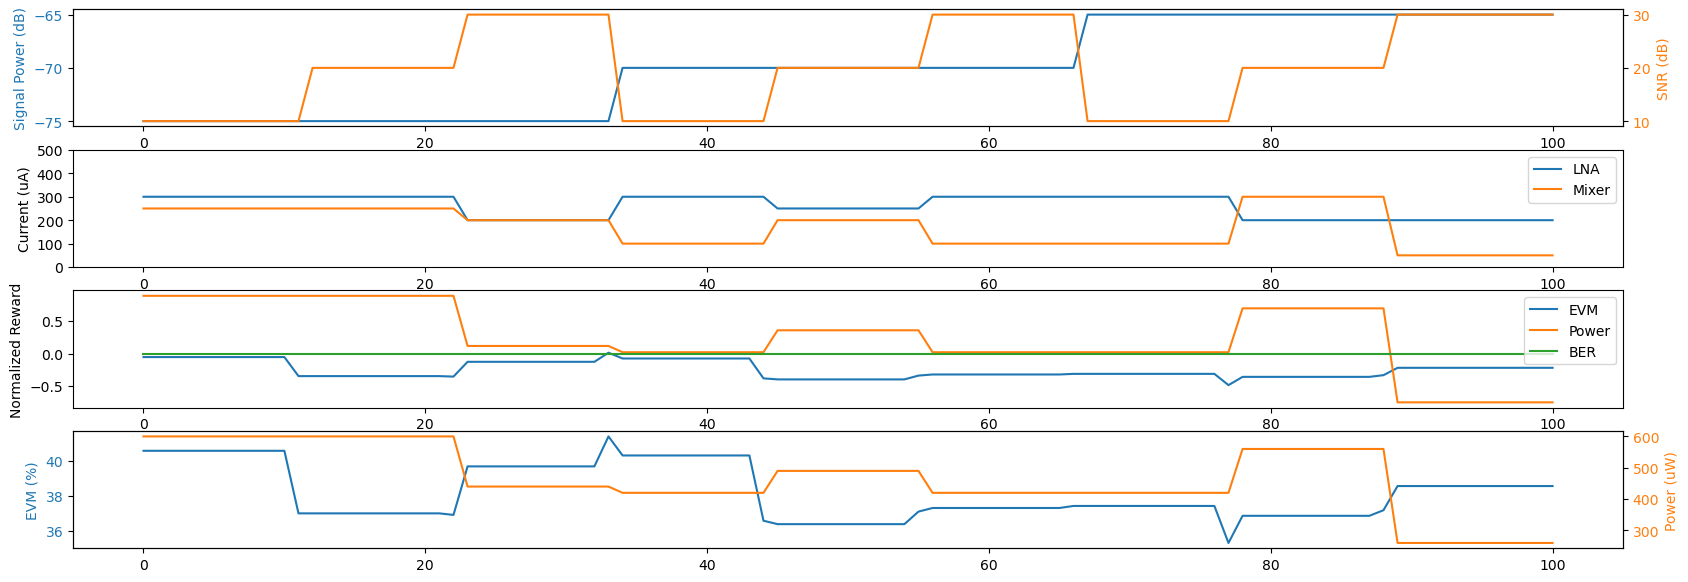

In [46]:
# %%
# For evaluation, improve the communication environment step by step and check the actions
cumulative_rewards_test = []
signal_powers = []
snrs = []
EVMs = []
powers = []
BERs = []
EVMs_Normalized = []
powers_Normalized = []
BERs_Normalized = []
lna_currents = []
mixer_currents = []

# Initialize the environment and get its state
env = rf_env(dataset_dir)
state, _, _, _ = env.improve_comm_env()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

# print(f"Signal Power: {signal_powers[-1]}\tSNR: {snrs[-1]}")

cumulative_reward_test = 0

for t in count():
    signal_powers.append(env.comm_config.SignalPower)
    snrs.append(env.comm_config.SNR)

    with torch.no_grad():
        action = policy_net(state).max(1).indices.view(1, 1)
    observation, reward, terminated, measures = env.improve_comm_env(action.item())
    lna_currents.append(env.getLNACurrent())
    mixer_currents.append(env.getMixerCurrent())

    cumulative_reward_test += reward
    EVMs.append(measures['rmsEVM'])
    powers.append(measures['Power'])
    BERs.append(measures['BER'])
    EVMs_Normalized.append(measures['rmsEVM_Normalized'])
    powers_Normalized.append(measures['Power_Normalized'])
    BERs_Normalized.append(measures['BER'])
    
    done = terminated
    if terminated:
        next_state = None
    else:
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    # Move to the next state
    state = next_state

    if done:
        cumulative_rewards_test.append(cumulative_reward_test)
        break

# plt.figure()
# plt.subplot(4, 1, 1)
# plt.plot(lna_currents)
# plt.title("LNA Current")
# plt.subplot(4, 1, 2)
# plt.plot(mixer_currents)
# plt.title("Mixer Current")
# plt.subplot(4, 1, 3)
# plt.plot(EVMs)
# plt.title("EVM")
# plt.subplot(4, 1, 4)
# plt.plot(powers)
# plt.title("Power Consumption")
# plt.show()

colors = ["tab:blue", "tab:orange"]

fig = plt.figure(figsize=(20, 7))
ax1 = plt.subplot(4, 1, 1)
ax1.plot(signal_powers, color=colors[0])
ax1.set_ylabel("Signal Power (dB)", color=colors[0])
ax1.tick_params(axis="y", labelcolor=colors[0])
ax1.set_yticks(rf_env.SignalPower_List)
ax2 = ax1.twinx()
ax2.plot(snrs, color=colors[1])
ax2.set_ylabel("SNR (dB)", color=colors[1])
ax2.tick_params(axis="y", labelcolor=colors[1])
ax2.set_yticks(rf_env.SNR_List)
plt.subplot(4, 1, 2)
plt.plot(lna_currents)
plt.plot(mixer_currents)
plt.ylabel("Current (uA)")
plt.legend(['LNA', 'Mixer'])
plt.yticks(list(range(0, 600, 100)))
plt.subplot(4, 1, 3)
plt.plot(EVMs_Normalized)
plt.plot(powers_Normalized)
plt.plot(BERs_Normalized)
plt.ylabel("Normalized Reward")
plt.legend(['EVM', 'Power', 'BER'])
ax1 = plt.subplot(4, 1, 4)
ax1.plot(EVMs, color=colors[0])
ax1.set_ylabel("EVM (%)", color=colors[0])
ax1.tick_params(axis="y", labelcolor=colors[0])
ax2 = ax1.twinx()
ax2.plot(powers, color=colors[1])
ax2.set_ylabel("Power (uW)", color=colors[1])
ax2.tick_params(axis="y", labelcolor=colors[1])
# print(f"EVM: min: {min(EVMs)}, max: {max(EVMs)}, range: {max(EVMs) - min(EVMs)}")
# print(f"Power: min: {min(powers)}, max: {max(powers)}, range: {max(powers) - min(powers)}")
plt.show()
fig.savefig(os.path.join(save_dir, "test_results_incremental.pdf"))





In [ ]:
# %%
fig = plt.figure()
cumulative_rewards_t = torch.tensor(cumulative_rewards, device=torch.device('cpu'))
cumulative_rewards_mean = cumulative_rewards_t.unfold(dimension=0, size=100, step=1).mean()
print(cumulative_rewards_t.unfold(dimension=0, size=100, step=1).mean(dim=1))
plt.plot(cumulative_rewards_t.unfold(dimension=0, size=100, step=1).mean(dim=1))
plt.show()
# fig.savefig(os.path.join(save_dir, "test_cumulative_results.pdf"))
